In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Set random seed
np.random.seed(42)

In [2]:
data = pd.read_csv('data.csv', index_col=0)
import sklearn.utils
data = sklearn.utils.shuffle(data)

labels = np.ravel(data[['type']],order='C')
data.drop(['date', 'userId', 'lat', 'lon', 'location', 'device', 'zip', 'zipcode', 'pressure', 'windDeg'],axis=1, inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 583 entries, d2134ea0-1e14-11e8-95a0-5bbfe3c5219b to 5f159ad0-6ad1-11e7-908f-4b064f587a76
Data columns (total 7 columns):
clouds         583 non-null int64
humidity       583 non-null int64
temp           583 non-null float64
type           583 non-null int64
visibility     583 non-null int64
weatherCond    583 non-null object
windSpeed      583 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 36.4+ KB


In [3]:
#force df to have same # of hot / iced rows
hot = data.loc[data.type == 1]
iced = data.loc[data.type == 0]

#remove all hot
data.drop(data[data.type == 1].index, inplace=True)

num_delete = hot.shape[0] - iced.shape[0]
indexes_to_keep = set(range(hot.shape[0])) - set(range(num_delete))
hot_sliced = hot.take(list(indexes_to_keep))

data = pd.concat([data, hot_sliced])
data['type'].value_counts()
labels = np.ravel(data[['type']],order='C')


In [4]:
print("iced", data[data['type']==0].shape)
print("hot",data[data['type']==1].shape)
# data.drop(['type'],axis=1, inplace=True)



iced (214, 7)
hot (214, 7)


In [5]:
#round data
def round(df):
    return df.apply(lambda x: np.rint(x))

data['temp'] = round(data['temp'])
# data['windDeg'] = round(data['windDeg'])
data['windSpeed'] = round(data['windSpeed'])

In [6]:
def to_bins(col, bins, lables):
    data[col] = pd.cut(data[col], bins=bins, labels=lables)
    return data[col]

def to_categorical(data, cat_vars):
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1=data.join(cat_list)
        data=data1
    data = data.drop(cat_vars, axis=1)
    return data

In [7]:

#convert visibilty from meters to miles
def miles(meter):
    return round(meter/1609.344)

data['visibility'] = miles(data['visibility'])
# bins = [0, 1, 5, 20]
# vis_lables = [0,1,2]

# data['visibility'] = to_bins("visibility", bins=bins, lables=vis_lables)
# # data = to_categorical(data, cat_vars=['visibility'])


In [8]:
# clouds binning
# cloud_bins = [0, 25, 50, 100]
# cloud_labels = [0, 1, 2]

# data['clouds'] = to_bins("clouds", bins=cloud_bins, lables=cloud_labels)
# data = to_categorical(data, cat_vars=['clouds'])



In [9]:
# humidity binning
# data['humidity'].value_counts()
# humidity_bins = [0, 25, 50, 100]
# humidity_labels = [0, 1, 2]

# data['humidity'] = to_bins("humidity", bins=humidity_bins, lables=humidity_labels)
# data = to_categorical(data, cat_vars=['humidity'])



In [10]:
data.head()

,clouds,humidity,temp,type,visibility,weatherCond,windSpeed
FC13E2E8-E047-459D-9DF6-04EB731F02B7,1,27,73.0,0,10.0,Clear,4.0
1D9C6B3D-B3F9-4F11-B1C2-24789DAD423E,1,35,72.0,0,10.0,Clear,8.0
35C1F5CE-F649-4B7C-A111-F7FDFD9A36DC,1,72,70.0,0,10.0,Clear,3.0
96DFDC31-350D-42FF-9D07-095F8AF9D33D,90,93,66.0,0,1.0,Mist,4.0
CEE6A9B7-DAF7-4DE0-8B21-21DC4A0CCFAB,75,100,64.0,0,3.0,Mist,6.0


In [11]:
data['weatherCond']
for index,rows in data.iterrows():
    if ("cloud" in data.loc[index, 'weatherCond'].lower() or "overcast" in data.loc[index, 'weatherCond'].lower()):
        data.loc[index, 'weatherCond'] = 'Clouds'
        
    if ("snow" in data.loc[index, 'weatherCond'].lower()):
        data.loc[index, 'weatherCond'] = 'Snow'
        
    if ("rain" in data.loc[index, 'weatherCond'].lower() or "drizzle" in data.loc[index, 'weatherCond'].lower() or "mist" in data.loc[index, 'weatherCond'].lower()):
        data.loc[index, 'weatherCond'] = 'Rain'
        
    if ("none" in data.loc[index, 'weatherCond'].lower()):
        data.loc[index, 'weatherCond'] = 'Clear'
    

data['weatherCond'].value_counts()

Clouds          174
Clear           126
Rain             95
Fog              13
Haze             10
Snow              7
Smoke             2
Thunderstorm      1
Name: weatherCond, dtype: int64

In [12]:
# one- hot encoding
cat_vars=['weatherCond']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
data = data.drop(['weatherCond'], axis=1)
data.head()

,clouds,humidity,temp,type,visibility,windSpeed,weatherCond_Clear,weatherCond_Clouds,weatherCond_Fog,weatherCond_Haze,weatherCond_Rain,weatherCond_Smoke,weatherCond_Snow,weatherCond_Thunderstorm
FC13E2E8-E047-459D-9DF6-04EB731F02B7,1,27,73.0,0,10.0,4.0,1,0,0,0,0,0,0,0
1D9C6B3D-B3F9-4F11-B1C2-24789DAD423E,1,35,72.0,0,10.0,8.0,1,0,0,0,0,0,0,0
35C1F5CE-F649-4B7C-A111-F7FDFD9A36DC,1,72,70.0,0,10.0,3.0,1,0,0,0,0,0,0,0
96DFDC31-350D-42FF-9D07-095F8AF9D33D,90,93,66.0,0,1.0,4.0,0,0,0,0,1,0,0,0
CEE6A9B7-DAF7-4DE0-8B21-21DC4A0CCFAB,75,100,64.0,0,3.0,6.0,0,0,0,0,1,0,0,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, FC13E2E8-E047-459D-9DF6-04EB731F02B7 to 5f159ad0-6ad1-11e7-908f-4b064f587a76
Data columns (total 14 columns):
clouds                      428 non-null int64
humidity                    428 non-null int64
temp                        428 non-null float64
type                        428 non-null int64
visibility                  428 non-null float64
windSpeed                   428 non-null float64
weatherCond_Clear           428 non-null uint8
weatherCond_Clouds          428 non-null uint8
weatherCond_Fog             428 non-null uint8
weatherCond_Haze            428 non-null uint8
weatherCond_Rain            428 non-null uint8
weatherCond_Smoke           428 non-null uint8
weatherCond_Snow            428 non-null uint8
weatherCond_Thunderstorm    428 non-null uint8
dtypes: float64(3), int64(3), uint8(8)
memory usage: 46.8+ KB


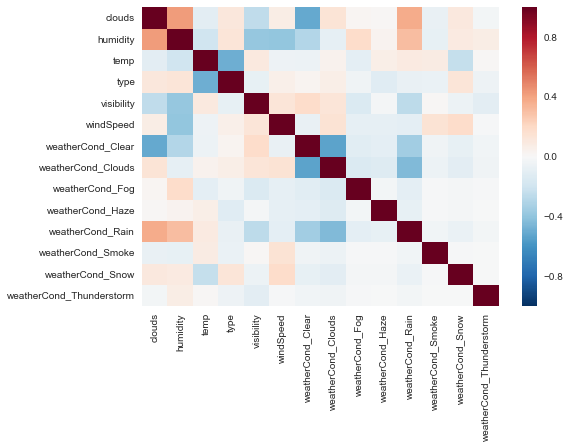

In [14]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [15]:
data.drop(['type'],axis=1, inplace=True)

In [16]:
print("data",data.shape)
print("labels", labels.shape)

data (428, 13)
labels (428,)


In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model, 4)
rfe = rfe.fit(data, labels)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False  True False  True False  True  True
 False]
[10  8  6  9  7  2  1  4  1  5  1  1  3]


In [18]:
X = data#data[['lat','lon', 'temp', 'windSpeed']]
y = labels
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


/Users/antoniohung/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
#save X_test


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.698


In [21]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
from sklearn.metrics import accuracy_score
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.698


In [23]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(y_test, rf.predict(X_test))))

Random Forest Accuracy: 0.729


In [24]:
#SVM
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print('Support vector machine accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test))))              

Support vector machine accuracy: 0.550


In [25]:
from sklearn import model_selection as ms
from sklearn.model_selection import cross_val_score
scoring = 'accuracy'


kfoldMean = ms.cross_val_score(svc, X_train, y_train, cv = ms.KFold(), scoring=scoring).mean()
Kfold_shuggle = ms.cross_val_score(svc, X_train, y_train, cv = ms.KFold(shuffle = True), scoring=scoring).mean()
print(kfoldMean)
print(Kfold_shuggle)

0.648956228956
0.662222222222


In [26]:
#save mode
import pickle
# filename = 'svc.sav'
filename = 'models/rf.sav'
pickle.dump(rf, open(filename, 'wb'), protocol=2)

In [27]:

#save mode
import pickle
filename = 'models/logreg.sav'
# filename = 'rf.sav'
pickle.dump(logreg, open(filename, 'wb'), protocol=2)

In [ ]:
file = open(filename, 'rb')
svc = pickle.load(file)
svc